100%|██████████| 4.74M/4.74M [00:00<00:00, 42.4MB/s]


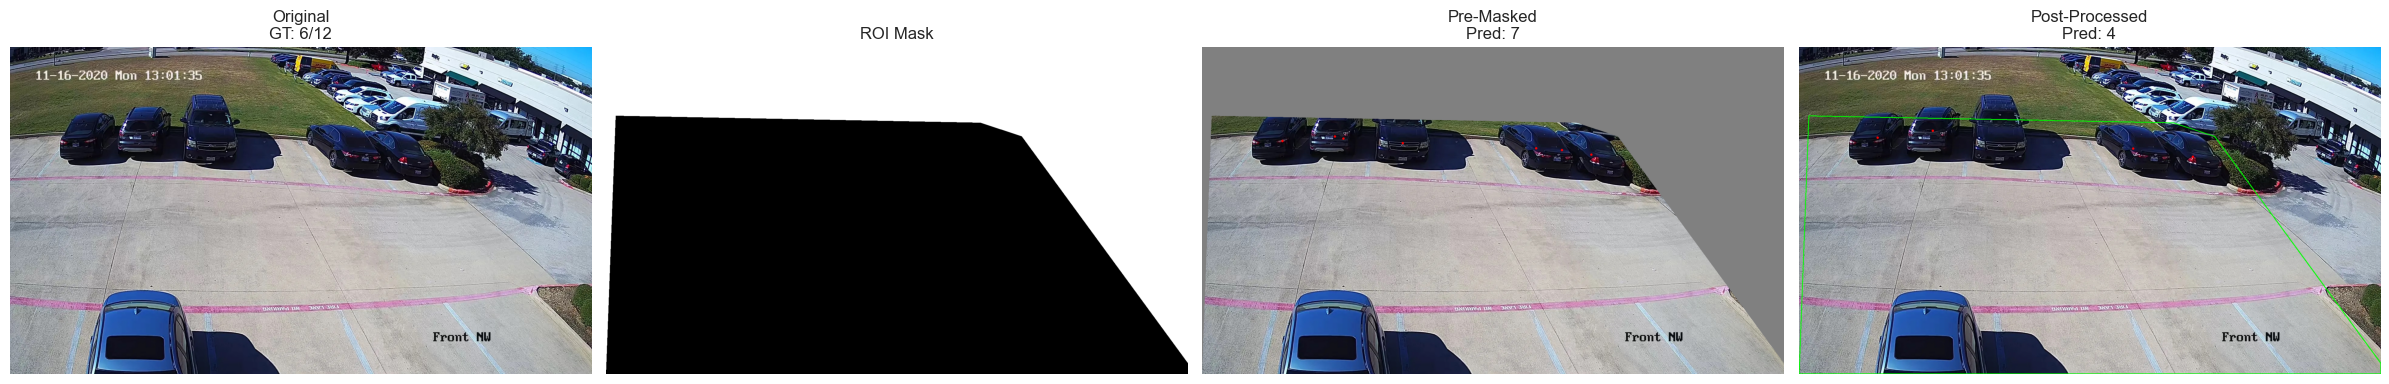

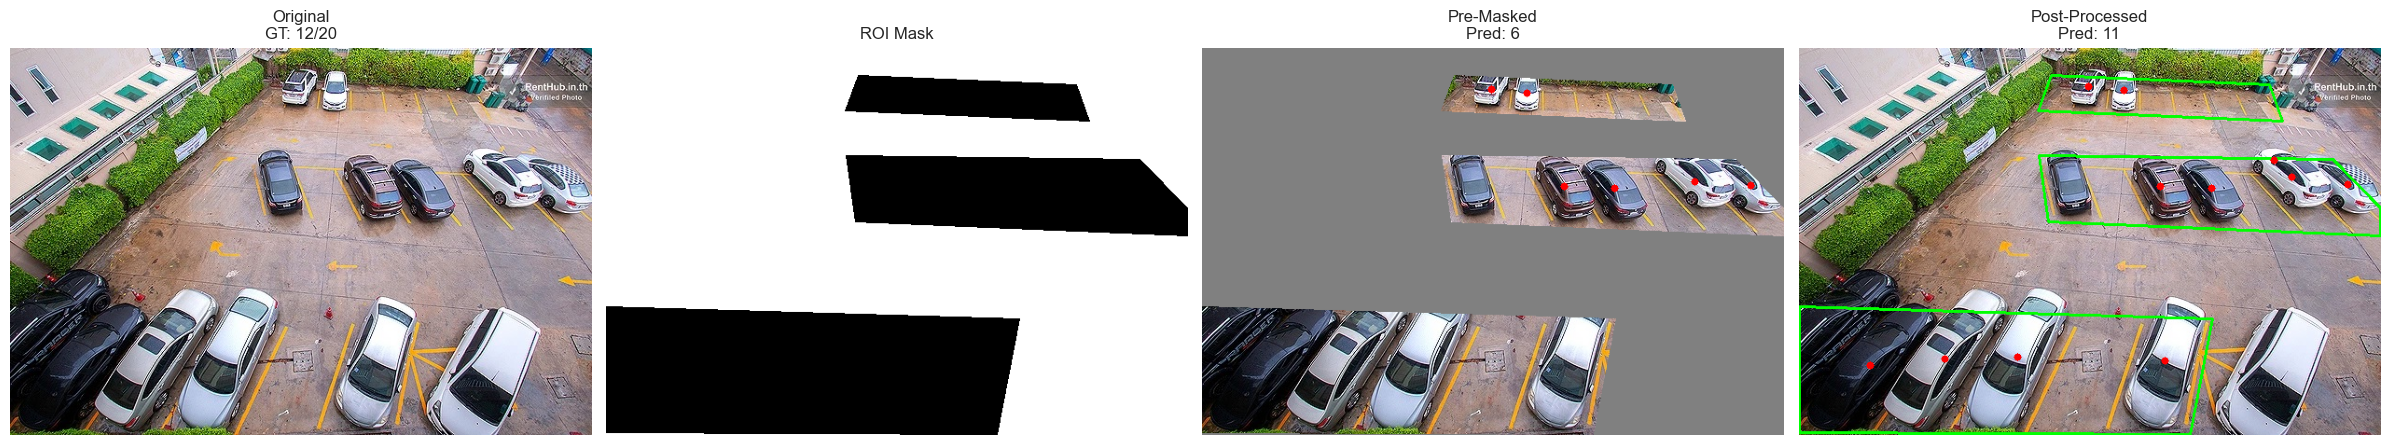

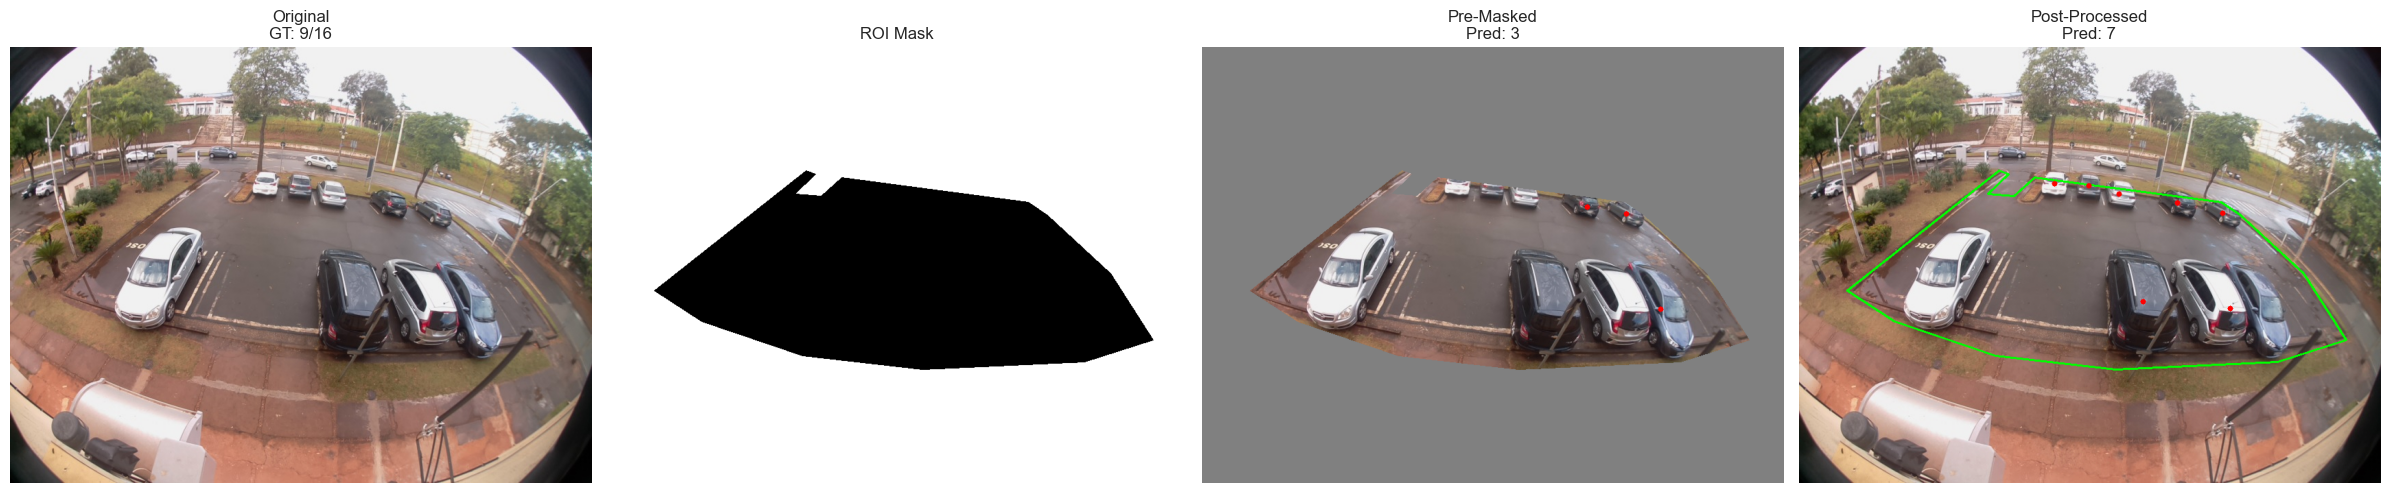

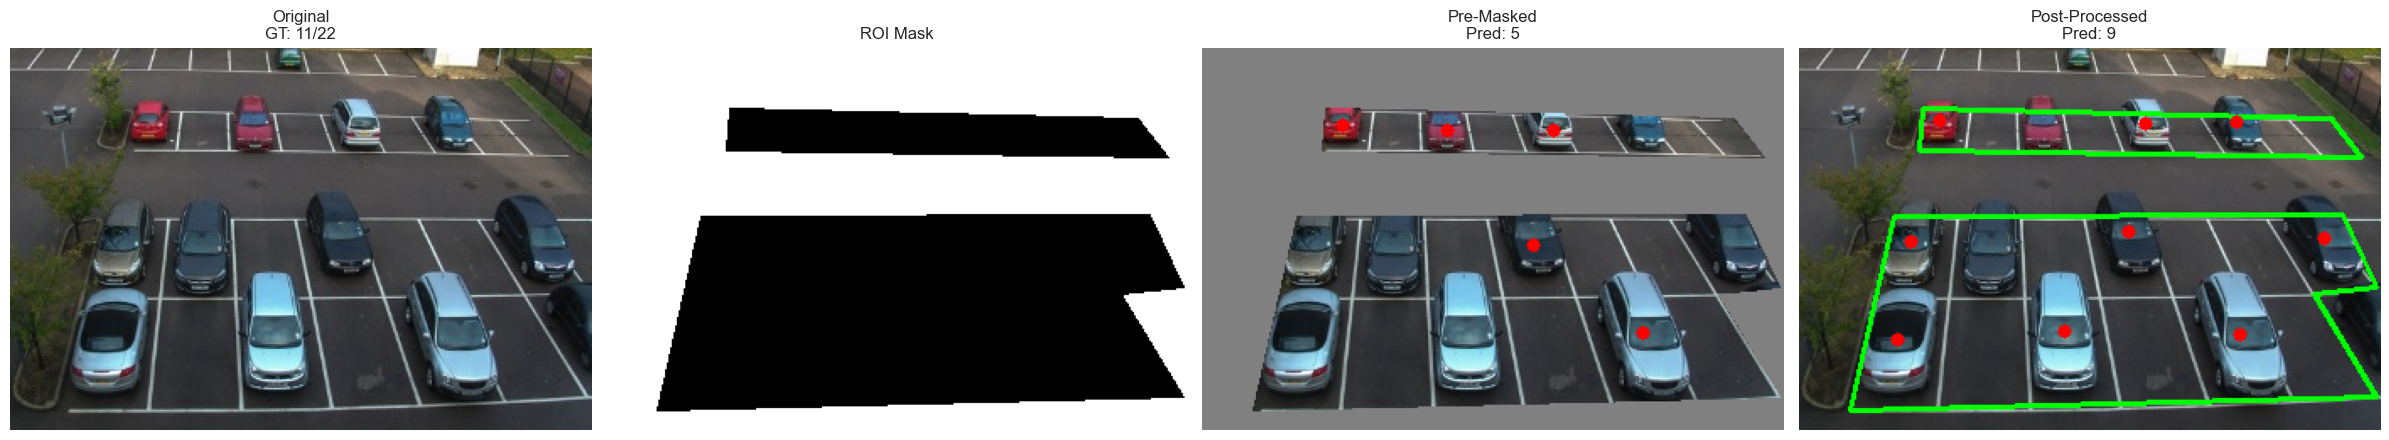

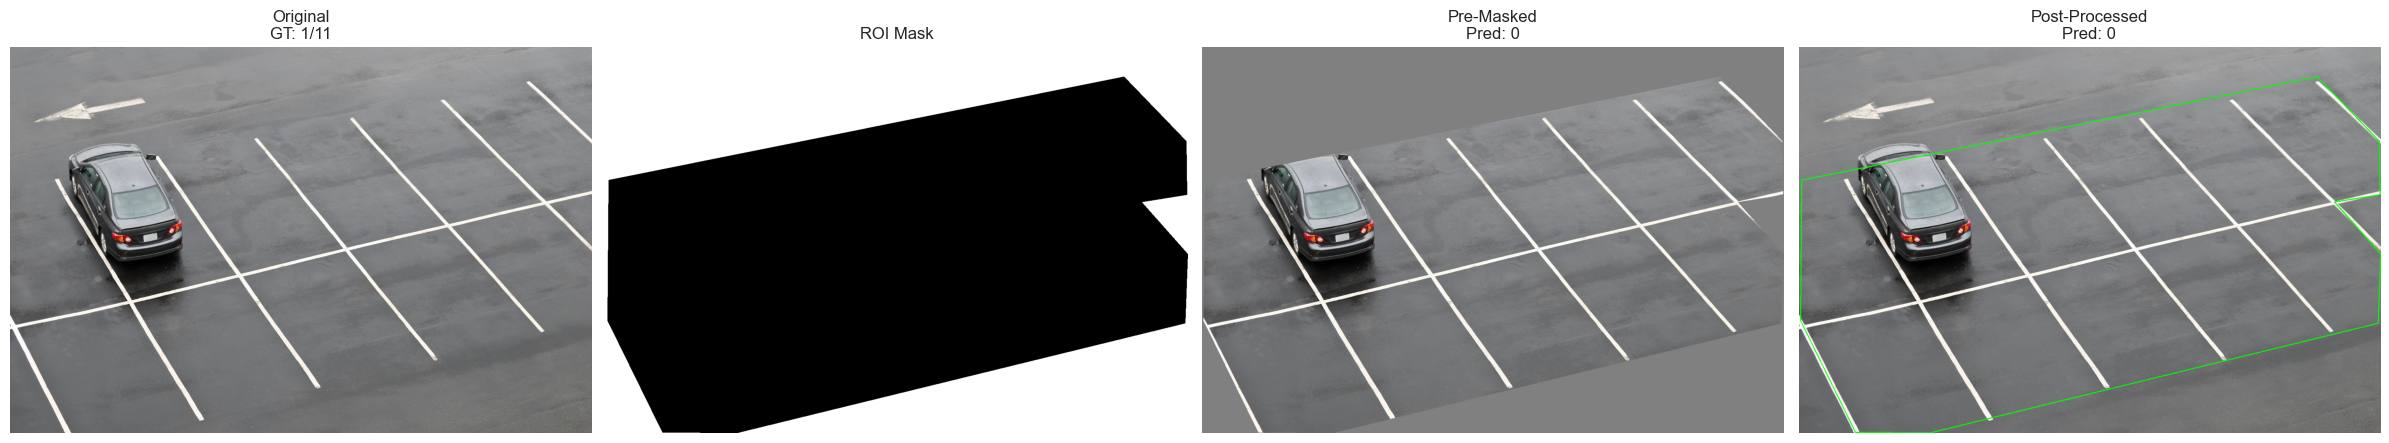

TP: 41, TN: 20, FP: 19, FN: 1
TP: 42, TN: 31, FP: 8, FN: 0

Pre-processing 방식
	Accuracy: 75.31%, F1-score: 0.8039
Post-processing 방식
	Accuracy: 90.12%, F1-score: 0.9130


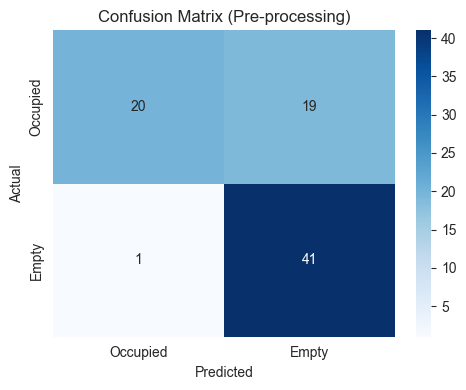

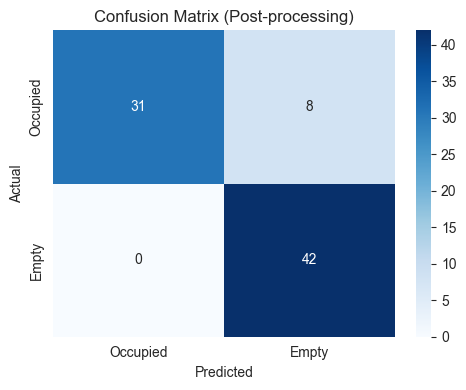

In [12]:
import cv2
import numpy as np
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt

# -------- 설정 --------
IMAGE_PATHS = [f for f in os.listdir('.') if f.endswith('.jpg')]  # 예: test_6_12.jpg → 차량 수 6대, 총 12칸
MODEL_PATH = 'yolov9t.pt'  # 사용할 YOLO 모델
TARGET_CLASS = 2  # 차량 클래스 (YOLO 모델에 따라 다름)
CONFIDENCE_THRESHOLD = 0.25  # 탐지 confidence threshold

# -------- 모델 로드 --------
model = YOLO(MODEL_PATH)

# -------- ROI 중심점 확인 --------
def is_inside_roi(xy, mask):
    x, y = int(xy[0]), int(xy[1])
    return 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and mask[y, x] == 0

# -------- ROI 마스크 로딩 --------
def load_roi_mask_from_txt(txt_path, image_shape):
    h, w = image_shape[:2]
    mask = np.ones((h, w), dtype=np.uint8) * 255
    polygons = []
    if not os.path.exists(txt_path):
        return mask, polygons
    with open(txt_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) < 7:
                continue
            coords = np.array([float(p) for p in parts[1:]]).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = np.int32([coords])
            cv2.fillPoly(mask, [polygon], 0)
            polygons.append(polygon)
    return mask, polygons

# -------- Pre 방식 마스킹 --------
def apply_pre_mask(image, mask):
    gray = np.full_like(image, 128)
    mask_3c = cv2.merge([mask, mask, mask])
    return np.where(mask_3c == 255, gray, image)

# -------- 탐지된 차량 수 및 중심 좌표 --------
def count_and_centers_pre(results):
    count = 0
    centers = []
    for box in results.boxes:
        if int(box.cls[0]) != TARGET_CLASS:
            continue
        x1, y1, x2, y2 = box.xyxy[0]
        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
        count += 1
        centers.append((cx, cy))
    return count, centers

def count_in_roi_post(results, mask):
    count = 0
    centers = []
    for box in results.boxes:
        if int(box.cls[0]) != TARGET_CLASS:
            continue
        x1, y1, x2, y2 = box.xyxy[0]
        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
        if is_inside_roi((cx, cy), mask):
            count += 1
            centers.append((cx, cy))
    return count, centers

# -------- Confusion Matrix 기반 평가 함수 --------
def evaluate_confusion(pred_counts, true_counts, total_slots_list):
    TP = TN = FP = FN = 0
    for pred, true, total in zip(pred_counts, true_counts, total_slots_list):
        pred_occupied = pred
        pred_empty = total - pred
        true_occupied = true
        true_empty = total - true

        TP += min(pred_empty, true_empty)  # 빈공간 정확히 예측
        TN += min(pred_occupied, true_occupied)  # 차량 정확히 예측
        FP += max(pred_empty - true_empty, 0)  # 빈공간 예측했지만 차량
        FN += max(true_empty - pred_empty, 0)  # 차량 예측했지만 빈공간

    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall = TP / (TP + FN) if (TP + FN) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    acc = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) else 0.0

    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    return acc, f1

# -------- 메인 루프 --------
y_true, y_pred_pre, y_pred_post, total_slots_list = [], [], [], []

for img_path in IMAGE_PATHS:
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    txt_path = img_path.replace('.jpg', '.txt')
    mask, polygons = load_roi_mask_from_txt(txt_path, (h, w))

    try:
        true_count, total_slots = map(int, img_path.replace('.jpg', '').split('_')[-2:])
    except:
        print(f"파일명에서 차량 수 추출 실패: {img_path}")
        continue

    y_true.append(true_count)
    total_slots_list.append(total_slots)

    # Pre 방식
    pre_img = apply_pre_mask(img, mask)
    result_pre = model(pre_img, verbose=False, conf=CONFIDENCE_THRESHOLD)[0]
    pre_count, pre_centers = count_and_centers_pre(result_pre)
    y_pred_pre.append(pre_count)

    # Post 방식
    result_post = model(img, verbose=False, conf=CONFIDENCE_THRESHOLD)[0]
    post_count, post_centers = count_in_roi_post(result_post, mask)
    y_pred_post.append(post_count)

    # 시각화
    pre_vis = pre_img.copy()
    for cx, cy in pre_centers:
        cv2.circle(pre_vis, (cx, cy), 4, (0, 0, 255), -1)

    post_vis = img.copy()
    for poly in polygons:
        cv2.polylines(post_vis, poly, isClosed=True, color=(0, 255, 0), thickness=2)
    for cx, cy in post_centers:
        cv2.circle(post_vis, (cx, cy), 4, (0, 0, 255), -1)

    # 시각화 출력
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Original\nGT: {true_count}/{total_slots}")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("ROI Mask")
    axs[1].axis('off')

    axs[2].imshow(cv2.cvtColor(pre_vis, cv2.COLOR_BGR2RGB))
    axs[2].set_title(f"Pre-Masked\nPred: {pre_count}")
    axs[2].axis('off')

    axs[3].imshow(cv2.cvtColor(post_vis, cv2.COLOR_BGR2RGB))
    axs[3].set_title(f"Post-Processed\nPred: {post_count}")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()

# -------- 결과 출력 --------
acc_pre, f1_pre = evaluate_confusion(y_pred_pre, y_true, total_slots_list)
acc_post, f1_post = evaluate_confusion(y_pred_post, y_true, total_slots_list)

print("\nPre-processing 방식")
print(f"\tAccuracy: {acc_pre*100:.2f}%, F1-score: {f1_pre:.4f}")
print("Post-processing 방식")
print(f"\tAccuracy: {acc_post*100:.2f}%, F1-score: {f1_post:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns

# -------- Confusion Matrix 그리기 --------
def plot_confusion_matrix(y_true, y_pred, total_slots, title):
    y_true_binary = []
    y_pred_binary = []

    for true, pred, total in zip(y_true, y_pred, total_slots):
        true_vector = [1] * true + [0] * (total - true)
        pred_vector = [1] * pred + [0] * (total - pred)

        # 길이 맞추기 (길이가 다르면 자를 수밖에 없음)
        min_len = min(len(true_vector), len(pred_vector))
        y_true_binary.extend(true_vector[:min_len])
        y_pred_binary.extend(pred_vector[:min_len])

    cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Occupied', 'Empty'], yticklabels=['Occupied', 'Empty'])
    plt.title(f'Confusion Matrix ({title})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# -------- confusion matrix 시각화 호출 --------
plot_confusion_matrix(y_true, y_pred_pre, total_slots_list, "Pre-processing")
plot_confusion_matrix(y_true, y_pred_post, total_slots_list, "Post-processing")


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from sklearn.cluster import DBSCAN

def cluster_parking_rows(boxes, eps_y=20, min_samples=1):
    centers_y = np.array([ (y1 + y2) / 2 for (x1, y1, x2, y2, cls_id, conf) in boxes ]).reshape(-1, 1)
    clustering = DBSCAN(eps=eps_y, min_samples=min_samples, metric='euclidean')
    row_ids = clustering.fit_predict(centers_y)
    return row_ids

def compute_row_rectangles(boxes, row_ids, padding=0):
    row_rects = []
    unique_rows = sorted(set(row_ids))
    for rid in unique_rows:
        if rid < 0:
            continue
        idxs = [i for i, r in enumerate(row_ids) if r == rid]
        if not idxs:
            continue
        x1_vals = [boxes[i][0] for i in idxs]
        y1_vals = [boxes[i][1] for i in idxs]
        x2_vals = [boxes[i][2] for i in idxs]
        y2_vals = [boxes[i][3] for i in idxs]
        x_min = int(min(x1_vals) - padding)
        y_min = int(min(y1_vals) - padding)
        x_max = int(max(x2_vals) + padding)
        y_max = int(max(y2_vals) + padding)
        x_min, y_min = max(0, x_min), max(0, y_min)
        row_rects.append((rid, x_min, y_min, x_max, y_max, idxs))
    return row_rects

def run_yolo_on_image(image_path, model, conf):
    im0 = cv2.imread(image_path)
    if im0 is None:
        raise FileNotFoundError(f"이미지를 읽을 수 없습니다: {image_path}")
    results = model(im0, verbose=False, conf=conf)[0]
    yolo_boxes = results.boxes
    boxes = []
    for i in range(len(yolo_boxes)):
        xyxy = yolo_boxes.xyxy[i].cpu().numpy()
        conf = float(yolo_boxes.conf[i].cpu().numpy())
        cls_id = int(yolo_boxes.cls[i].cpu().numpy())
        x1, y1, x2, y2 = map(int, xyxy)
        boxes.append((x1, y1, x2, y2, cls_id, conf))
    return im0, boxes

def is_point_in_box(px, py, box):
    x1, y1, x2, y2 = box
    return x1 <= px <= x2 and y1 <= py <= y2

def visualize_parking_and_illegal(image_path, model_slot, model_car):
    im0, boxes_slot = run_yolo_on_image(image_path, model_slot, conf=0.5)
    _, boxes_car = run_yolo_on_image(image_path, model_car, conf=0.6)

    if not boxes_slot:
        print("🔍 주차공간 바운딩 박스 없음")
        return im0

    row_ids = cluster_parking_rows(boxes_slot, eps_y=30, min_samples=1)
    row_rects = compute_row_rectangles(boxes_slot, row_ids, padding=0)
    vis = im0.copy()

    car_boxes = [ (x1, y1, x2, y2) for (x1, y1, x2, y2, cls_id, conf) in boxes_car ]
    legal_car_count_per_row = {rid: 0 for rid, *_ in row_rects}
    car_assigned = [False] * len(car_boxes)

    # ✅ Step 1: 중심점 기반 정상 주차 판단
    for idx, (x1, y1, x2, y2) in enumerate(car_boxes):
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2  # 차량 중심점

        for rid, x_min, y_min, x_max, y_max, _ in row_rects:
            if is_point_in_box(cx, cy, (x_min, y_min, x_max, y_max)):
                legal_car_count_per_row[rid] += 1
                car_assigned[idx] = True
                break  # 한 row에만 배정

    # Step 3: 주차 표시
    for idx, assigned in enumerate(car_assigned):
        if not assigned:
            x1, y1, x2, y2 = car_boxes[idx]
            cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 0, 255), 2)
        else:
            x1, y1, x2, y2 = car_boxes[idx]
            cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Step 2: row 표시 + 주차된 차량 수
    for (rid, x_min, y_min, x_max, y_max, idxs) in row_rects:
        total_spaces = len(idxs)
        occupied = legal_car_count_per_row.get(rid, 0)
        text = f"{occupied}/{total_spaces}"
        cv2.rectangle(vis, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(vis, (x_min, y_min - text_h - 8), (x_min + text_w + 8, y_min), (255, 255, 255), -1)
        cv2.putText(vis, text, (x_min + 4, y_min - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2, cv2.LINE_AA)

    return vis


if __name__ == "__main__":
    model_slot = YOLO("pklot.pt")        # 주차공간 탐지용
    model_car = YOLO("visDrone.pt")      # 차량 탐지용
    img_path = "test_1_11.jpg"

    output_vis = visualize_parking_and_illegal(img_path, model_slot, model_car)

    save_path = "parking_illegal_marked.png"
    cv2.imwrite(save_path, output_vis)
    print(f"✔️ 결과가 '{save_path}' 로 저장되었습니다.")

    cv2.imshow("Parking + Illegal Detection", output_vis)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


🔍 주차공간 바운딩 박스 없음
✔️ 결과가 'parking_illegal_marked.png' 로 저장되었습니다.


2025-06-15 21:07:50.111 python[75559:6396795] +[IMKClient subclass]: chose IMKClient_Modern
2025-06-15 21:07:50.111 python[75559:6396795] +[IMKInputSession subclass]: chose IMKInputSession_Modern
